In [1]:
import os
os.chdir("../../../")

In [2]:
import torch
from torchts.nn.models.ode import ODESolver
import numpy as np

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
# Duffing equation: Second order ODE system
dt = 0.01

def x_prime(prev_val, coeffs):
    return prev_val["x_"]

def x_prime_prime(prev_val, coeffs):
    return coeffs["g"]*torch.cos(coeffs["w"]*prev_val["t"]) - coeffs["d"]*prev_val["x_"] - coeffs["a"]*prev_val["x"] - coeffs["b"]*prev_val["x"]*prev_val["x"]*prev_val["x"]

def t_prime(prev_val, coeffs):
    return 1

ode = {"x": x_prime, "x_": x_prime_prime, "t": t_prime}

# Initial conditions [0,0,0]
ode_init = {"x": 0, "x_": 0, "t": 0}

# Constants (Parameters)
ode_coeffs = {"a": 0.1, "b": 0.5, "d": 0.2, "g": 0.8, "w": 0.5}


# 4th Order Runge-Kutta - Data Generation for nt = 1000

In [4]:
ode_solver = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_coeffs,
    dt=dt,
    solver="rk4",
    optimizer=None
)

result = ode_solver(1000)

In [5]:
result

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.9973e-05, 7.9920e-03, 1.0000e-02],
        [1.5979e-04, 1.5968e-02, 2.0000e-02],
        ...,
        [1.3451e-01, 1.5991e-01, 9.9701e+00],
        [1.3612e-01, 1.6162e-01, 9.9801e+00],
        [1.3774e-01, 1.6335e-01, 9.9901e+00]], grad_fn=<StackBackward>)

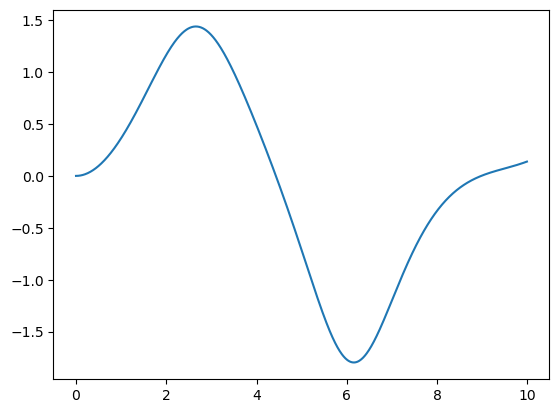

In [6]:
result_np = result.detach().numpy() # Convert to numpy array

# 2D plot of X and Z
plt.plot(result_np[:,2], result_np[:,0])

plt.show()

# Euler's method for training

In [7]:
ode_train_coeffs = {"a": 0., "b": 0., "d": 0., "g": 0., "w": 1.}

ode_solver_train = ODESolver(
    ode=ode,
    init_vars=ode_init,
    init_coeffs=ode_train_coeffs,
    dt=dt,
    solver="rk4",
    optimizer=None
)

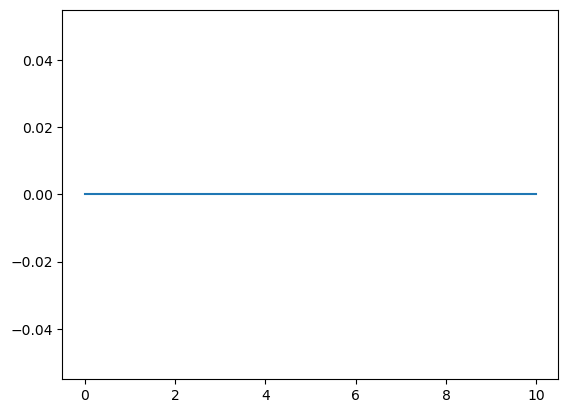

In [8]:
results_test = ode_solver_train(1000)
results_test_np = results_test.detach().numpy() # Convert to numpy array

# 2D plot of X and Z
plt.plot(results_test_np[:,2], results_test_np[:,0])

plt.show()

In [9]:
ode_solver_train.fit_random_sample(
    result,torch.optim.Adam,
    {"lr": 0.1},
    max_epochs=10
)

Epoch: 0	 Loss: tensor(8.9032e-06, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(0.0939, requires_grad=True), 'b': Parameter containing:
tensor(0.2094, requires_grad=True), 'd': Parameter containing:
tensor(-0.2346, requires_grad=True), 'g': Parameter containing:
tensor(0.6090, requires_grad=True), 'w': Parameter containing:
tensor(1.2538, requires_grad=True)}
Epoch: 1	 Loss: tensor(4.9188e-08, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(0.0489, requires_grad=True), 'b': Parameter containing:
tensor(0.3273, requires_grad=True), 'd': Parameter containing:
tensor(-0.1743, requires_grad=True), 'g': Parameter containing:
tensor(0.5939, requires_grad=True), 'w': Parameter containing:
tensor(1.1477, requires_grad=True)}
Epoch: 2	 Loss: tensor(4.3954e-06, grad_fn=<MseLossBackward>)
{'a': Parameter containing:
tensor(-0.2185, requires_grad=True), 'b': Parameter containing:
tensor(0.3450, requires_grad=True), 'd': Parameter containing:
tensor(-0.3001, requires_

In [10]:
ode_solver_train.coeffs

# The coefficients differ by at most 0.1 from the original with the exception of "w". THe graphs look similar.
# TODO: Investigate why "w" isn't learning

{'a': Parameter containing:
 tensor(-0.5913, requires_grad=True),
 'b': Parameter containing:
 tensor(0.2579, requires_grad=True),
 'd': Parameter containing:
 tensor(-0.1300, requires_grad=True),
 'g': Parameter containing:
 tensor(0.4061, requires_grad=True),
 'w': Parameter containing:
 tensor(1.1630, requires_grad=True)}

# Predictions for nt = 10000

In [11]:
results_test = ode_solver_train(10000)
results_test

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0315e-05,  4.0638e-03,  1.0000e-02],
        [ 8.1293e-05,  8.1327e-03,  2.0000e-02],
        ...,
        [-2.5672e+00, -2.0745e+03,  9.9973e+01],
        [-2.3307e+01, -2.0681e+03,  9.9983e+01],
        [-4.3622e+01, -1.9648e+03,  9.9993e+01]], grad_fn=<StackBackward>)

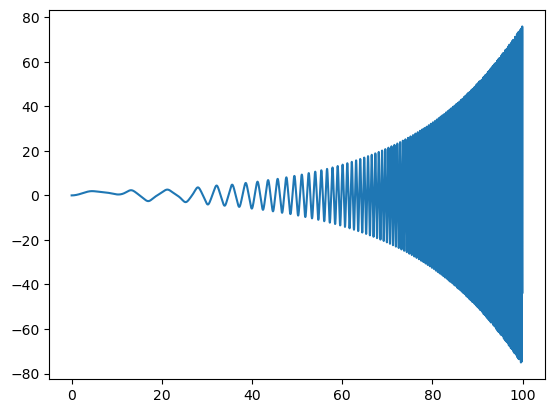

In [12]:
results_test_np = results_test.detach().numpy() # Convert to numpy array

# 2D plot
plt.plot(results_test_np[:,2], results_test_np[:,0])

plt.show()

In [13]:
import scipy.io

scipy.io.savemat("Duffing_fitRandomSample.mat", {"x": results_test_np})